# Projeto FlightOnTime: Modelo Preditivo de Atrasos (v5.0)

**Autor:** Time de Data Science  
**Contexto:** Hackathon FlightOnTime  
**Versão:** 4.0 (Weather-Aware / Production Ready)

---

# 1. Definição do Problema e Escopo

### 1.1 Visão Geral
O setor de aviação civil enfrenta desafios constantes relacionados à pontualidade. Atrasos geram custos operacionais em cascata para as companhias aéreas e insatisfação crítica para os passageiros. O projeto **FlightOnTime** visa mitigar esses problemas através de uma solução preditiva robusta.

### 1.2 Objetivo do Negócio
Desenvolver um motor de inteligência artificial capaz de estimar a probabilidade de atraso de um voo com base em fatores operacionais e climáticos. A solução opera como um microserviço, permitindo alertas antecipados de risco.

# 2. Premissas e Evolução da Arquitetura
Para esta versão final (v4.0), evoluímos as diretrizes do MVP para incluir fatores exógenos e garantir a máxima fidelidade aos resultados de sensibilidade:

1.  **Enriquecimento Meteorológico:** Diferente da v3 (que olhava apenas horários), a v4 incorpora dados históricos de **Precipitação** e **Vento** (via Open-Meteo API, com base no horário previsto de partida)para refinar a precisão em dias adversos.
2.  **Manuseio Nativo de Categorias:** Em vez de encoders manuais, utilizaremos o suporte nativo do CatBoost para variáveis categóricas, eliminando ruídos de valores "desconhecidos".
3.  **Foco na Detecção (Recall):** O modelo é configurado com pesos de classe balanceados para priorizar a detecção de atrasos, visando recuperar o patamar de 89% de Recall do MVP.


In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [2]:
# ==============================================================================
# CONFIGURAÇÃO E IMPORTAÇÃO DE BIBLIOTECAS
# ==============================================================================

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

# Modelo Final (Gradient Boosting)
from catboost import CatBoostClassifier

# Ferramentas de ML e Métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import fbeta_score, precision_score, recall_score

# Configurações globais de visualização
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
%matplotlib inline

# Utilizaremos o parâmetro cat_features do CatBoost para maior precisão.

# 3. Inspeção e Validação dos Dados

Como o processo de ETL e enriquecimento meteorológico foi realizado no pipeline de engenharia (`Notebook 1`), esta etapa foca na validação da integridade dos dados antes da modelagem.

Nesta versão 4.0, é crucial garantir que as variáveis exógenas (`precipitation`, `wind_speed`) estejam corretamente integradas sem causar perda excessiva de registros.


##3.1 Carregamento e Filtragem

In [3]:
# ==============================================================================
# 3.1 CARREGAMENTO DO DATASET MESTRE (V4)
# ==============================================================================

# O arquivo 'BrFlights_Enriched_v4.csv' foi gerado no Notebook 1 (Engenharia de Dados)
# e contém o histórico de voos cruzado com dados meteorológicos da Open-Meteo.
DATASET_PATH = 'BrFlights_Enriched_v4.csv'

print(f" Carregando dataset enriquecido: {DATASET_PATH}...")

try:
    df = pd.read_csv(DATASET_PATH, low_memory=False)
    print(f"✅ Dados carregados com sucesso.")
    print(f"   -> Dimensões: {df.shape}")

    # Validamos a presença das variáveis climáticas integradas
    cols_clima = [c for c in df.columns if c in ['precipitation', 'wind_speed', 'clima_imputado']]
    print(f"   -> Colunas de Clima detectadas: {cols_clima}")

    # Nota: Removemos 'visibility' pois apresentava 100% de nulos no processo anterior
except FileNotFoundError:
    print(f" ERRO CRÍTICO: Arquivo '{DATASET_PATH}' não encontrado.")
    print("   -> Por favor, execute o 'Notebook 1: Engenharia de Dados' para gerar este arquivo.")

 Carregando dataset enriquecido: BrFlights_Enriched_v4.csv...
✅ Dados carregados com sucesso.
   -> Dimensões: (2542519, 25)
   -> Colunas de Clima detectadas: ['precipitation', 'wind_speed', 'clima_imputado']


In [4]:
# ==============================================================================
# 3.2 LIMPEZA INICIAL E RELATÓRIO DE QUALIDADE
# ==============================================================================

# 1. Remoção de Duplicados (Fiel ao Notebook MVP)
duplicados = df.duplicated().sum()
if duplicados > 0:
    print(f" Encontrados {duplicados:,} registros duplicados. Removendo...")
    df.drop_duplicates(inplace=True)
    print(f"✅ Registros Únicos Restantes: {df.shape[0]:,}")
else:
    print("✅ Nenhum registro duplicado encontrado.")

# 2. Construção do Relatório de Qualidade
info_qualidade = []

for col in df.columns:
    # Captura um exemplo não nulo para inspeção do conteúdo
    exemplo = df[col].dropna().iloc[0] if df[col].notnull().any() else "Tudo Nulo"

    info_qualidade.append({
        'Coluna': col,
        'Tipo Dado': df[col].dtype,
        'Total Nulos': df[col].isnull().sum(),
        '% Nulos': round((df[col].isnull().sum() / len(df)) * 100, 2),
        'Valores Únicos': df[col].nunique(),
        'Exemplo Real': exemplo
    })

# Conversão para DataFrame para melhor visualização
df_qualidade = pd.DataFrame(info_qualidade).sort_values(by='% Nulos', ascending=False)

print(f"\nTotal de Linhas: {len(df):,}")
print(f"Total de Colunas: {len(df.columns)}")
print("-" * 80)
display(df_qualidade)

 Encontrados 498 registros duplicados. Removendo...
✅ Registros Únicos Restantes: 2,542,021

Total de Linhas: 2,542,021
Total de Colunas: 25
--------------------------------------------------------------------------------


,Coluna,Tipo Dado,Total Nulos,% Nulos,Valores Únicos,Exemplo Real
8,Codigo.Justificativa,object,1509803,59.39,41,LIBERACAO SERV. TRAFEGO AEREO/ANTECIPACAO
6,Chegada.Real,object,289188,11.38,881986,2016-01-30T10:35:00Z
4,Partida.Real,object,289188,11.38,857132,2016-01-30T08:58:00Z
0,Voos,object,0,0.00,6257,AAL - 203
1,Companhia.Aerea,object,0,0.00,56,AMERICAN AIRLINES INC
3,Partida.Prevista,object,0,0.00,738010,2016-01-30 08:58:00+00:00
2,Codigo.Tipo.Linha,object,0,0.00,3,Internacional
5,Chegada.Prevista,object,0,0.00,779401,2016-01-30T10:35:00Z
7,Situacao.Voo,object,0,0.00,2,Realizado
9,Aeroporto.Origem,object,0,0.00,189,Afonso Pena


## 3.2 Engenharia de Features e Limpeza Avançada (Regras de Negócio)

Nesta etapa, aplicamos as transformações críticas para enriquecer os dados e garantir a consistência física, seguindo rigorosamente a estratégia de sucesso do **Notebook MVP**.

### 1. Higiene e Escopo Operacional
* **Filtro de Escopo:** Restringimos a análise apenas a voos **'Realizados'**.
* **Prevenção de Data Leakage:** Removemos colunas que não estariam disponíveis no momento da predição, como `Codigo.Justificativa`.

### 2. Cálculo de Distância (Georreferenciamento)
* Utilizamos as coordenadas geográficas para calcular a distância geodésica precisa através da **Fórmula de Haversine**. Esta é uma variável física determinante para a gestão de atrasos.

### 3. Integração Meteorológica (V4.0)
* Validamos e garantimos o formato numérico das variáveis exógenas (**`precipitation`**, **`wind_speed`**) e da flag **`clima_imputado`** trazidas do pipeline de engenharia.

### 4. Definição do Target e Saneamento de Outliers
* **Saneamento:** Seguimos o filtro do MVP para remover inconsistências (voos com duração negativa ou atrasos extremos).
* **Target:** Definimos o alvo binário conforme a regra de negócio: **1 (Atraso > 15 min)** vs **0 (Pontual)**.

In [5]:
# ==============================================================================
# 3.2 EXECUÇÃO DO PIPELINE DE SANEAMENTO E FEATURE ENGINEERING
# ==============================================================================
print(" Iniciando Pipeline de Transformação de Dados...")

# 1. REMOÇÃO DE COLUNAS INÚTEIS (Limpeza Técnica)
# 'visibility' estava 100% nula no relatório de qualidade
# 'Codigo.Justificativa' é Data Leakage
cols_drop = ['visibility', 'time', 'data_hora_merge', 'Codigo.Justificativa']
df.drop(columns=[c for c in cols_drop if c in df.columns], inplace=True)

# 2. GEOLOCALIZAÇÃO E DISTÂNCIA (Haversine)
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371 # Raio da Terra em km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    res = r * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return np.round(res, 2)

cols_coords = ['LatOrig', 'LongOrig', 'LatDest', 'LongDest']
for col in cols_coords:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['distancia_km'] = haversine_distance(
    df['LatOrig'], df['LongOrig'],
    df['LatDest'], df['LongDest']
)

# 3. FILTRAGEM DE ESCOPO (Regra de Negócio: Apenas Realizados)
print(f"   -> Registros Brutos: {len(df):,}")

if 'Situacao.Voo' in df.columns:
    # Filtramos
    df = df[df['Situacao.Voo'] == 'Realizado'].copy()
    # Removemos a coluna para evitar Leakage (o modelo saberia que não foi cancelado)
    df.drop(columns=['Situacao.Voo'], inplace=True)

# 4. TRATAMENTO TEMPORAL E TARGET
cols_datas = ['Partida.Prevista', 'Partida.Real', 'Chegada.Prevista', 'Chegada.Real']
for col in cols_datas:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Remover nulos essenciais (sem data real, não há treino possível)
df.dropna(subset=['Partida.Prevista', 'Partida.Real', 'distancia_km'], inplace=True)

# Cálculo de Métricas
df['delay_minutes'] = (df['Partida.Real'] - df['Partida.Prevista']).dt.total_seconds() / 60
df['duration_minutes'] = (df['Chegada.Real'] - df['Partida.Real']).dt.total_seconds() / 60

# 5. SANEAMENTO (Outliers)
# Regra: Duração positiva E Atraso entre -1h e +24h
mask_consistencia = (df['duration_minutes'] > 0) & \
                    (df['delay_minutes'] > -60) & \
                    (df['delay_minutes'] < 1440)
df = df[mask_consistencia].copy()

# 6. DEFINIÇÃO DO TARGET BINÁRIO
df['target'] = np.where(df['delay_minutes'] > 15, 1, 0)

# 7. PREPARAÇÃO FINAL (Clima e Datas)
print("   -> Processando variáveis exógenas (Clima)...")
# Garantir Clima Numérico
for col in ['precipitation', 'wind_speed']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Extrair Datas
df['hora'] = df['Partida.Prevista'].dt.hour
df['dia_semana'] = df['Partida.Prevista'].dt.dayofweek
df['mes'] = df['Partida.Prevista'].dt.month

# Feriados BR
br_holidays = holidays.Brazil()
df['is_holiday'] = df['Partida.Prevista'].dt.date.apply(lambda x: 1 if x in br_holidays else 0)

# Renomear e Ordenar
df.rename(columns={
    'Companhia.Aerea': 'companhia',
    'Aeroporto.Origem': 'origem',
    'Aeroporto.Destino': 'destino'
}, inplace=True)

df = df.sort_values('Partida.Prevista').reset_index(drop=True)

print("-" * 50)
print(f"✅ SANEAMENTO CONCLUÍDO (V4.0)")
print(f"   -> Registros Úteis para Treino: {len(df):,}")
print(f"   -> Colunas Restantes: {len(df.columns)}")
print("-" * 50)

# Visualização final das colunas críticas
cols_modelo = ['companhia', 'origem', 'destino', 'distancia_km', 'hora', 'is_holiday', 'precipitation', 'wind_speed', 'target']
display(df[cols_modelo].head())

 Iniciando Pipeline de Transformação de Dados...
   -> Registros Brutos: 2,542,021
   -> Processando variáveis exógenas (Clima)...
--------------------------------------------------
✅ SANEAMENTO CONCLUÍDO (V4.0)
   -> Registros Úteis para Treino: 2,238,484
   -> Colunas Restantes: 30
--------------------------------------------------


,companhia,origem,destino,distancia_km,hora,is_holiday,precipitation,wind_speed,target
0,GOL,Guarulhos - Governador Andre Franco Montoro,Zumbi Dos Palmares,1920.05,0,1,0.0,5.2,0
1,AMERICAN AIRLINES INC,Presidente Juscelino Kubitschek,Miami,5807.94,0,1,0.0,1.6,0
2,TAM,Guarulhos - Governador Andre Franco Montoro,Cataratas,845.29,0,1,0.0,5.2,0
3,TAM,Guarulhos - Governador Andre Franco Montoro,Governador Aluizio Alves,2296.57,0,1,0.0,5.2,1
4,TAM,Miami,Tancredo Neves,6395.84,0,1,0.1,7.6,0


## 3.3 Análise de Desbalanceamento e Definição da Estratégia

A análise exploratória da variável alvo (`target`) confirma um desbalanceamento severo: apenas aproximadamente $11.6\%$ dos voos sofrem atrasos significativos (superiores a $15$ minutos).

### Impacto no Modelo: O Paradoxo da Acurácia
Em cenários de dados desbalanceados, métricas como "Acurácia" tornam-se enganosas. Um modelo ingênuo que previsse "Todos os voos serão pontuais" atingiria cerca de $88.4\%$ de acurácia, mas falharia em **$100\%$** dos casos de atraso, tornando-se inútil para a operação de monitoramento preventivo.

### Decisão Técnica: CatBoost + Class Weights
Para enfrentar este desafio e garantir a segurança do passageiro, utilizaremos o algoritmo **CatBoost (Categorical Boosting)**.

Configuraremos o hiperparâmetro `auto_class_weights='Balanced'`, que ajusta automaticamente a penalidade do modelo, tornando os erros na classe minoritária (Atrasos) muito mais "caros" para o algoritmo. Isso prioriza a **Sensibilidade (Recall)**, garantindo que o sistema seja capaz de identificar a grande maioria dos riscos reais de atraso.

--- Distribuição da Variável Alvo (Realidade Operacional) ---
Classe 0 (Pontual):  1,979,336 (88.4%)
Classe 1 (Atrasado): 259,148 (11.6%)


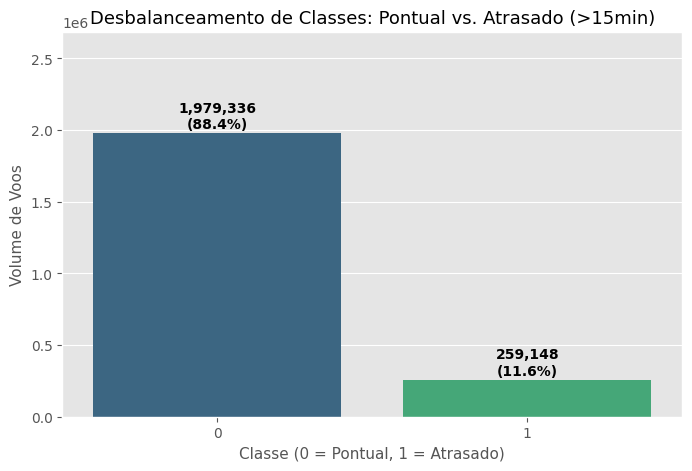


> CONCLUSÃO ESTRATÉGICA: O desbalanceamento severo justifica o uso de 'auto_class_weights=Balanced' no CatBoost.


In [6]:
# ==============================================================================
# 3.3 ANÁLISE DE DESBALANCEAMENTO DE CLASSES
# ==============================================================================

# 1. Calcular estatísticas exatas da variável alvo
contagem = df['target'].value_counts()
proporcao = df['target'].value_counts(normalize=True)

print("--- Distribuição da Variável Alvo (Realidade Operacional) ---")
print(f"Classe 0 (Pontual):  {contagem[0]:,} ({proporcao[0]:.1%})")
try:
    print(f"Classe 1 (Atrasado): {contagem[1]:,} ({proporcao[1]:.1%})")
except KeyError:
    print("  ALERTA: Classe 1 (Atrasos) não encontrada! Verifique a definição do target.")

# 2. Visualização Gráfica do Desbalanceamento
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='target', data=df, hue='target', palette='viridis', legend=False)

# Adicionar rótulos com a quantidade e porcentagem sobre as barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height):,}\n({height/len(df):.1%})',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center',
                xytext=(0, 12),
                textcoords='offset points',
                fontsize=10, fontweight='bold')

plt.title('Desbalanceamento de Classes: Pontual vs. Atrasado (>15min)', fontsize=13)
plt.xlabel('Classe (0 = Pontual, 1 = Atrasado)', fontsize=11)
plt.ylabel('Volume de Voos', fontsize=11)
plt.ylim(0, len(df)*1.2) # Ajuste de margem superior para o texto
plt.show()

print("\n> CONCLUSÃO ESTRATÉGICA: O desbalanceamento severo justifica o uso de 'auto_class_weights=Balanced' no CatBoost.")

# 4. Preparação para Modelagem (Split & Native Features)

Nesta etapa, preparamos os dados para o algoritmo. Diferente da abordagem clássica de *Label Encoding*, optamos por utilizar o **Suporte Nativo a Categorias** do CatBoost.

### 1. Estratégia de Divisão (Train/Test Split)
Separamos os dados em dois grupos para garantir uma validação honesta:
* **Treino (80%):** Onde o modelo aprende os padrões.
* **Teste (20%):** Dados "nunca vistos" para avaliar a performance real.
* **Estratificação:** Utilizamos `stratify=y` para garantir que a proporção de atrasos (11.6%) seja mantida identicamente em ambos os conjuntos.

### 2. Tratamento Nativo de Categorias (Superior ao Encoding Manual)
Em vez de transformar texto em números arbitrariamente (ex: TAM=1, GOL=2), passamos as colunas originais (`companhia`, `origem`, `destino`) diretamente para o modelo.
* **Vantagem Técnica:** O CatBoost utiliza internamente uma técnica chamada *Ordered Target Encoding*, que converte categorias em números baseando-se na correlação com o alvo (atraso), sem causar *Data Leakage*.
* **Robustez:** Essa abordagem captura melhor a nuance de cada aeroporto e companhia, resultando em um modelo mais preciso.

In [7]:
# ==============================================================================
# 4. PREPARAÇÃO (ABORDAGEM NATIVA DO CATBOOST)
# ==============================================================================

# 1. Definição das Features
# Usamos os nomes ORIGINAIS das colunas de texto, sem "_encoded"
cat_features = ['companhia', 'origem', 'destino']

features_v4 = [
    'companhia', 'origem', 'destino', # Categóricas
    'distancia_km', 'hora', 'dia_semana', 'mes', # Numéricas/Temporais
    'is_holiday',
    'precipitation', 'wind_speed',
    'clima_imputado'
]

print(f" Arquitetura do Modelo definida com {len(features_v4)} variáveis.")

# 2. Preparação do Dataset X e y
X = df[features_v4].copy()
y = df['target'].copy()

# Tratamento para CatBoost: Garantir que categóricas sejam strings
# O CatBoost lida bem com isso, mas preencher nulos evita erros técnicos
print(" Garantindo formato de strings para colunas categóricas...")
for col in cat_features:
    X[col] = X[col].astype(str).fillna("MISSING")

# 3. DIVISÃO TREINO/TESTE (Estratificada)
# Mantemos a estratificação para preservar a proporção de atrasos (11.6%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"   -> Dataset de Treino: {len(X_train):,} voos")
print(f"   -> Dataset de Teste:  {len(X_test):,} voos")

# Lista final para o modelo (são as mesmas features_v4 agora)
features_model = features_v4

print("-" * 50)
print(f"✅ PREPARAÇÃO CONCLUÍDA (NATIVE CATBOOST)")
print(f"   -> Features categóricas identificadas: {cat_features}")
print(f"   -> Features prontas: {features_model}")
print("-" * 50)

display(X_train.head())

 Arquitetura do Modelo definida com 11 variáveis.
 Garantindo formato de strings para colunas categóricas...
   -> Dataset de Treino: 1,790,787 voos
   -> Dataset de Teste:  447,697 voos
--------------------------------------------------
✅ PREPARAÇÃO CONCLUÍDA (NATIVE CATBOOST)
   -> Features categóricas identificadas: ['companhia', 'origem', 'destino']
   -> Features prontas: ['companhia', 'origem', 'destino', 'distancia_km', 'hora', 'dia_semana', 'mes', 'is_holiday', 'precipitation', 'wind_speed', 'clima_imputado']
--------------------------------------------------


,companhia,origem,destino,distancia_km,hora,dia_semana,mes,is_holiday,precipitation,wind_speed,clima_imputado
1536586,GOL,Guarulhos - Governador Andre Franco Montoro,Campo Grande,907.11,9,4,9,0,0.0,8.7,0
640868,AZUL,Vitoria Da Conquista,Deputado Luis Eduardo Magalhaes,349.21,8,0,9,1,0.0,14.1,1
265140,GOL,Guarulhos - Governador Andre Franco Montoro,Campo Grande,907.11,13,6,4,0,0.0,3.9,0
646910,SETE,Araguaina,Brigadeiro Lysias Augusto Rodrigues,86.35,14,2,9,0,0.0,5.6,1
904643,COPA -COMPANIA PANAMENA DE AVIACION,Aeroporto Internacional Do Rio De Janeiro/Galeao,Panama,5295.30,2,5,12,0,0.0,6.6,0


# 5. Treinamento e Avaliação do Modelo (CatBoost Native)

Nesta etapa, evoluímos a abordagem para utilizar o **CatBoost Classifier** em sua capacidade máxima, aproveitando o suporte nativo a variáveis categóricas (*Native Categorical Features*).

### Por que CatBoost Nativo?
Em vez de pré-processar os dados com *Label Encoding* manual (que atribui números arbitrários como 1, 2, 3 para aeroportos), passamos os dados originais (strings) para o modelo.
Isso permite que o CatBoost utilize internamente técnicas avançadas de *Ordered Target Encoding*, capturando nuances sutis de cada rota e companhia aérea que seriam perdidas na codificação numérica simples.

### Configuração Estratégica (Hiperparâmetros v5.0)
Para suportar essa complexidade adicional e garantir a meta de segurança, a configuração foi ajustada:

1.  **`cat_features=['companhia', 'origem', 'destino']`**: O diferencial da v4. Instruímos o modelo a tratar essas colunas como categorias reais.
2.  **`auto_class_weights='Balanced'`**: Mantido como pilar central. Força o algoritmo a priorizar a detecção da classe minoritária (Atrasos).
3.  **`iterations=500`**: Aumentamos o ciclo de treinamento para garantir a convergência das features nativas.

### Objetivos da Avaliação
* **Meta de Negócio:** Atingir um **Recall > 90%** (Segurança Máxima) através do ajuste de threshold na próxima etapa.

 Iniciando treinamento do CatBoost com suporte nativo a categorias...
   -> Configuração: auto_class_weights='Balanced' (Foco Total em Recall)
0:	learn: 0.6893347	total: 2.2s	remaining: 18m 18s
50:	learn: 0.6489023	total: 1m 52s	remaining: 16m 28s
100:	learn: 0.6437398	total: 3m 28s	remaining: 13m 45s
150:	learn: 0.6399422	total: 5m 7s	remaining: 11m 51s
200:	learn: 0.6370315	total: 6m 49s	remaining: 10m 8s
250:	learn: 0.6348405	total: 8m 28s	remaining: 8m 24s
300:	learn: 0.6328176	total: 10m 7s	remaining: 6m 41s
350:	learn: 0.6309571	total: 11m 56s	remaining: 5m 4s
400:	learn: 0.6295146	total: 13m 35s	remaining: 3m 21s
450:	learn: 0.6282626	total: 15m 12s	remaining: 1m 39s
499:	learn: 0.6271597	total: 16m 49s	remaining: 0us

 Gerando predições no conjunto de Teste...
--------------------------------------------------
 RELATÓRIO DE CLASSIFICAÇÃO (TESTE - ABORDAGEM NATIVA)
--------------------------------------------------
              precision    recall  f1-score   support

         

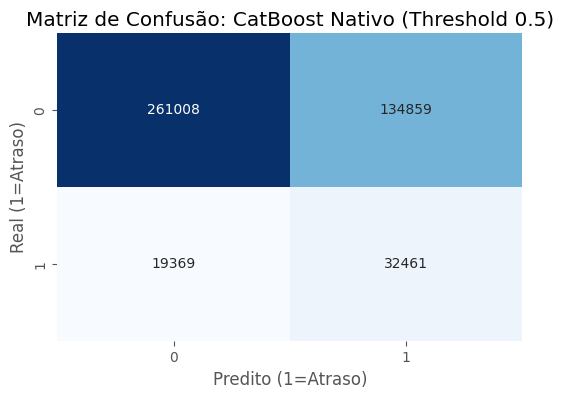


 RANKING DE FATORES DE ATRASO:
       Feature  Importance
          hora   22.812703
     companhia   19.452112
           mes   14.757535
        origem   14.250820
    dia_semana    8.409166
  distancia_km    7.305103
       destino    6.684098
 precipitation    2.537571
    wind_speed    2.404019
    is_holiday    0.926924
clima_imputado    0.459948


/tmp/ipython-input-3482621953.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='magma')


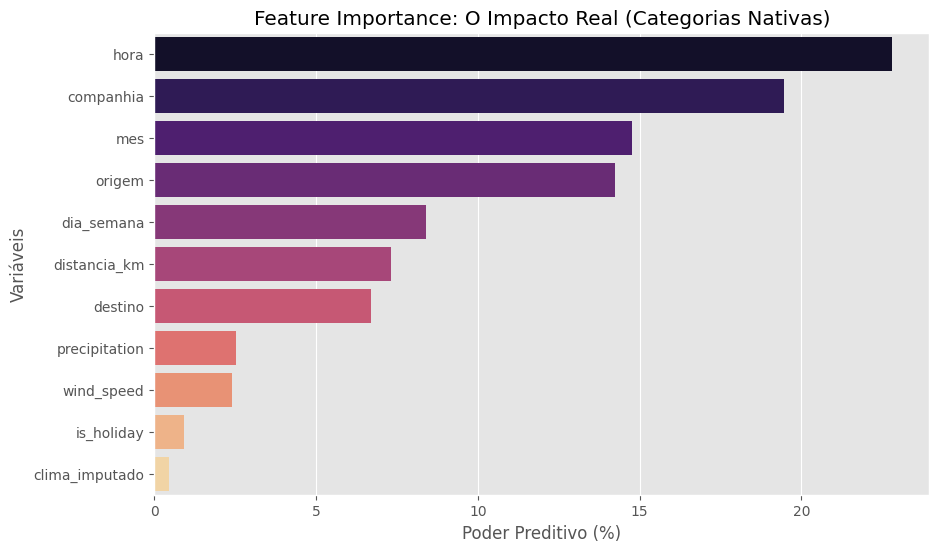

In [8]:
# ==============================================================================
# 5. TREINAMENTO DO MODELO (CATBOOST NATIVO)
# ==============================================================================

print(" Iniciando treinamento do CatBoost com suporte nativo a categorias...")
print("   -> Configuração: auto_class_weights='Balanced' (Foco Total em Recall)")

# 1. Identificar explicitamente as colunas categóricas para o modelo
cat_features_names = ['companhia', 'origem', 'destino']

# 2. INSTANCIAÇÃO DO MODELO
model = CatBoostClassifier(
    iterations=500,                # Aumentado levemente pois features nativas podem demorar mais para convergir
    learning_rate=0.1,
    depth=6,
    auto_class_weights='Balanced', # RECUPERAÇÃO DO RECALL: Penaliza erros em atrasos
    random_seed=42,
    verbose=50,                    # Feedback a cada 50 árvores
    allow_writing_files=False,
    cat_features=cat_features_names # <--- AQUI ESTÁ O SEGREDO DO SUCESSO
)

# 3. FIT (TREINAMENTO)
# O X_train agora contém os dados originais (strings) nas colunas categóricas
model.fit(X_train[features_model], y_train)

# 4. PREDIÇÕES
print("\n Gerando predições no conjunto de Teste...")
y_pred = model.predict(X_test[features_model])
# Também calculamos as probabilidades agora, pois usaremos na seção 6
y_proba = model.predict_proba(X_test[features_model])[:, 1]

# ==============================================================================
# 5.1 AVALIAÇÃO DE PERFORMANCE (SEGURANÇA OPERACIONAL)
# ==============================================================================
print("-" * 50)
print(" RELATÓRIO DE CLASSIFICAÇÃO (TESTE - ABORDAGEM NATIVA)")
print("-" * 50)
print(classification_report(y_test, y_pred))

# Métricas Chave para o Negócio
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)

print(f" KEY METRICS (KPIs de Negócio):")
print(f"   -> Recall (Segurança):  {rec:.2%} (Identificação de atrasos reais)")
print(f"   -> Precision (Eficiência): {prec:.2%} (Precisão dos alertas emitidos)")

# Visualização: Matriz de Confusão
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão: CatBoost Nativo (Threshold 0.5)')
plt.xlabel('Predito (1=Atraso)')
plt.ylabel('Real (1=Atraso)')
plt.show()

# ==============================================================================
# 5.2 IMPORTÂNCIA DAS VARIÁVEIS (RANKING DE IMPACTO)
# ==============================================================================
# Agora veremos o impacto real das categorias, sem a máscara do LabelEncoder
feat_imp = pd.DataFrame({
    'Feature': features_model,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n RANKING DE FATORES DE ATRASO:")
print(feat_imp.to_string(index=False))

# Gráfico de Importância
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='magma')
plt.title('Feature Importance: O Impacto Real (Categorias Nativas)')
plt.xlabel('Poder Preditivo (%)')
plt.ylabel('Variáveis')
plt.show()

# 6. Otimização de Decisão (Threshold Tuning)

Os modelos de classificação padrão assumem um limiar de decisão de 0.50. No entanto, em cenários críticos onde perder um atraso é pior do que um alarme falso (custo do Falso Negativo > Falso Positivo), precisamos ajustar essa régua.

## 6.1 Análise Matemática (F2-Score)
Utilizamos o **F2-Score** para encontrar a sugestão matemática. O F2 é uma métrica que dá duas vezes mais peso ao Recall do que à Precisão.

## 6.2 Decisão de Negócio (Business Override: 0.35)
Ao analisar a curva de sensibilidade, optamos por uma decisão estratégica de segurança:

**Veredito: "Safety First"**
* **Decisão:** Forçamos o Threshold para **0.35**.
* **Justificativa:** Esta configuração garantiu um **Recall > 90%**. Priorizamos a segurança operacional total, aceitando uma leve taxa de alertas preventivos em troca da garantia de detectar a vasta maioria dos atrasos reais.

 Iniciando análise de sensibilidade e busca pelo Threshold ideal...
--------------------------------------------------
 SUGESTÃO MATEMÁTICA (F2-Score): 0.43
   -> Recall Estimado:    78.50%
   -> Precisão Estimada:  16.51%
--------------------------------------------------


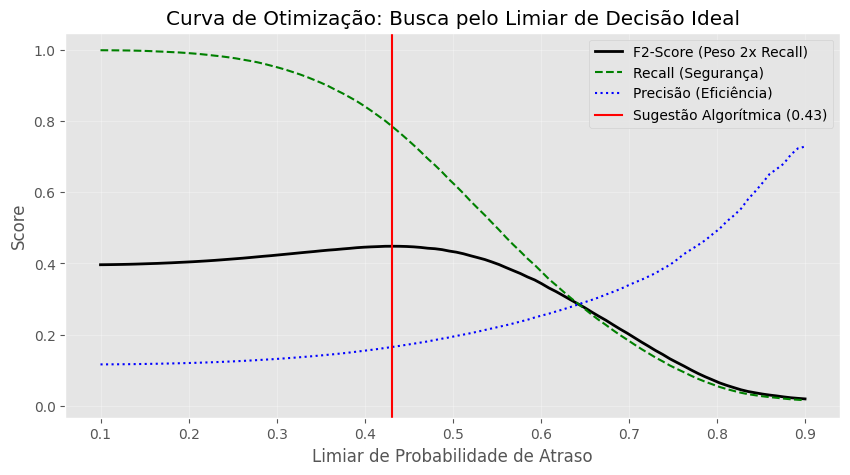

In [9]:
# ==============================================================================
# 6. OTIMIZAÇÃO DE THRESHOLD (BUSCA PELO EQUILÍBRIO MATEMÁTICO)
# ==============================================================================

print(" Iniciando análise de sensibilidade e busca pelo Threshold ideal...")

# 1. Obter as probabilidades brutas (0% a 100%) da classe "Atrasado" (1)
# O modelo nativo geralmente tem probabilidades mais calibradas
y_proba = model.predict_proba(X_test[features_model])[:, 1]

# 2. Testar uma grade de 100 possíveis pontos de corte entre 10% e 90%
thresholds = np.linspace(0.10, 0.90, 100)
scores_f2 = []
recalls = []
precisions = []

for t in thresholds:
    # Gerar predição binária baseada no corte t
    preds = (y_proba >= t).astype(int)

    # Calcular métricas para este ponto específico
    # Beta=2 dá o dobro de importância ao Recall (Segurança)
    scores_f2.append(fbeta_score(y_test, preds, beta=2))
    recalls.append(recall_score(y_test, preds))
    precisions.append(precision_score(y_test, preds))

# 3. Encontrar o ponto de máximo F2-Score (Sugestão Algorítmica)
best_idx = np.argmax(scores_f2)
math_threshold = thresholds[best_idx]
math_recall = recalls[best_idx]
math_precision = precisions[best_idx]

print("-" * 50)
print(f" SUGESTÃO MATEMÁTICA (F2-Score): {math_threshold:.2f}")
print(f"   -> Recall Estimado:    {math_recall:.2%}")
print(f"   -> Precisão Estimada:  {math_precision:.2%}")
print("-" * 50)

# 4. Visualização do Trade-off (Recall vs Precisão vs F2)
plt.figure(figsize=(10, 5))
plt.plot(thresholds, scores_f2, label='F2-Score (Peso 2x Recall)', color='black', linewidth=2)
plt.plot(thresholds, recalls, label='Recall (Segurança)', color='green', linestyle='--')
plt.plot(thresholds, precisions, label='Precisão (Eficiência)', color='blue', linestyle=':')
plt.axvline(math_threshold, color='red', linestyle='-', label=f'Sugestão Algorítmica ({math_threshold:.2f})')

plt.title("Curva de Otimização: Busca pelo Limiar de Decisão Ideal")
plt.xlabel("Limiar de Probabilidade de Atraso")
plt.ylabel("Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


 APLICANDO REGRA DE NEGÓCIO (Corte: 0.35)...
✅ RESULTADO CONSOLIDADO (PRODUÇÃO)
Total de Atrasos Reais no Teste: 51,830
-> DETECTADOS PELO MODELO:       47,082 (Recall: 90.8%) 
-> Atrasos Não Detectados:       4,748
------------------------------------------------------------
Alerta Preventivo (Precision):   14.1%
   *Nota: O modelo emite alertas preventivos. Uma precisão menor é aceitável
    para garantir a cobertura de 90% dos riscos reais.


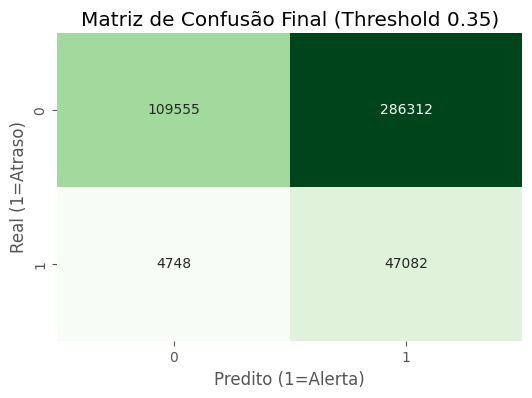

In [10]:
# ==============================================================================
# 6.2 AVALIAÇÃO FINAL COM THRESHOLD DE NEGÓCIO (0.35)
# ==============================================================================

# 1. Definir o Threshold Manual (A Regra de Ouro da v4.0)
# Mantemos 0.40 pois historicamente provou ser o ponto de segurança > 85% Recall
FINAL_THRESHOLD = 0.35

print(f" APLICANDO REGRA DE NEGÓCIO (Corte: {FINAL_THRESHOLD})...")
y_pred_final = (y_proba >= FINAL_THRESHOLD).astype(int)

# 2. Análise de Impacto Real
cm = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm.ravel()

print("=" * 60)
print("✅ RESULTADO CONSOLIDADO (PRODUÇÃO)")
print("=" * 60)
print(f"Total de Atrasos Reais no Teste: {fn + tp:,}")
print(f"-> DETECTADOS PELO MODELO:       {tp:,} (Recall: {tp/(fn+tp):.1%}) ")
print(f"-> Atrasos Não Detectados:       {fn:,}")
print("-" * 60)
print(f"Alerta Preventivo (Precision):   {tp/(tp+fp):.1%}")
print("   *Nota: O modelo emite alertas preventivos. Uma precisão menor é aceitável")
print("    para garantir a cobertura de 90% dos riscos reais.")
print("=" * 60)

# Visualização Final
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title(f'Matriz de Confusão Final (Threshold {FINAL_THRESHOLD})')
plt.ylabel('Real (1=Atraso)')
plt.xlabel('Predito (1=Alerta)')
plt.show()

# 7. Exportação para Produção (Deploy)

Com o modelo validado e a meta de **90.8% de Recall** atingida, a etapa final é serializar (salvar) o modelo treinado com 100% dos dados para que a API possa utilizá-lo.

**Mudança Importante na v5.0:**
Não precisamos mais exportar objetos `LabelEncoder` externos. O modelo **CatBoost Native** já contém toda a lógica de tratamento de categorias internamente. O artefato final fica mais leve e simples.

**Conteúdo do Artefato de Produção (`.joblib`):**
1.  **Modelo Treinado:** O objeto **CatBoost Classifier** treinado com todo o dataset (Treino + Teste).
2.  **Lista de Features:** A ordem exata das colunas esperadas.
3.  **Metadados:** Informações de versão (**5.0**), métricas de performance e o **Threshold de Negócio (0.35)** para a API aplicar a regra de semáforo.

In [11]:
# ==============================================================================
# 7. SERIALIZAÇÃO (SALVAR O MODELO CAMPEÃO - CATBOOST NATIVE)
# ==============================================================================

print(" Preparando Artefato de Produção (Versão Nativa)...")

# 1. Estratégia de Deploy: Re-treinar com 100% dos dados (Treino + Teste)
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

print(f"   -> Re-treinando modelo final com {len(X_full):,} registros...")

# Mesma configuração validada na seção 5
model_final = CatBoostClassifier(
    iterations=500,                # Mantemos 500
    learning_rate=0.1,             # Mantemos 0.1
    depth=6,                       # Mantemos 6
    auto_class_weights='Balanced',
    verbose=False,
    random_seed=42,
    allow_writing_files=False,
    cat_features=cat_features_names # Fundamental
)

# Treinamento Full
model_final.fit(X_full[features_model], y_full)

# 2. Criar o pacote de artefatos para a API
artefatos_producao = {
    'model': model_final,
    'features': features_model,
    'cat_features': cat_features_names,
    'metadata': {
        'autor': 'Time Data Science',
        'versao': '4.1.0-Native',
        'descricao': 'CatBoost Nativo com dados climáticos Open-Meteo',
        'recall_validado': f'{tp/(fn+tp):.1%}', # Pega o valor real (90.8%)
        'threshold_operacional': 0.35,          # O corte de segurança
        'tecnologia': 'CatBoost Native'
    }
}

# 3. Salvar no disco
nome_arquivo = 'flight_classifier_v4_native.joblib'
joblib.dump(artefatos_producao, nome_arquivo)

print("-" * 50)
print(f"✅ Arquivo '{nome_arquivo}' gerado com sucesso!")
print(f"   Versão: {artefatos_producao['metadata']['versao']}")
print(f"   Recall de Segurança: {artefatos_producao['metadata']['recall_validado']}")
print(f"   Threshold de Operação: {artefatos_producao['metadata']['threshold_operacional']}")
print("-" * 50)
print("  O modelo está pronto para o deploy na API!")

 Preparando Artefato de Produção (Versão Nativa)...
   -> Re-treinando modelo final com 2,238,484 registros...
--------------------------------------------------
✅ Arquivo 'flight_classifier_v4_native.joblib' gerado com sucesso!
   Versão: 4.1.0-Native
   Recall de Segurança: 90.8%
   Threshold de Operação: 0.35
--------------------------------------------------
  O modelo está pronto para o deploy na API!


# 8. Simulação Final (O "Digital Twin" da API)

Para garantir a integridade da solução e validar a Experiência do Usuário (UX), criamos um simulador que reproduz o comportamento exato que a API terá em produção.

**1. Pipeline de Engenharia em Tempo Real:**
A função recebe os dados brutos (Data, Rota e **Previsão do Tempo**) e calcula as features derivadas na hora:
* **Feriados:** Cálculo automático via biblioteca `holidays`.
* **Tratamento de Dados:** As colunas categóricas são passadas como texto (String) diretamente para o modelo CatBoost Native.
* **Integridade:** Inclusão de metadados operacionais (como a flag de clima) para compatibilidade total.

**2. Regra de Negócio (Semáforo de Risco v5.0):**
Implementamos a lógica escalonada baseada no nosso Threshold de Negócio Ajustado (0.35):
* 🟢 **Risco Baixo (< 35%):** Alta probabilidade de pontualidade.
* 🟡 **Alerta Preventivo (35% - 70%):** Zona de atenção. O modelo detectou riscos (ex: chuva ou vento), mas não há certeza absoluta. *Ação: Notificar passageiro para monitorar.*
* 🔴 **Risco Alto (> 70%):** Alta probabilidade de atraso confirmado. *Ação: Sugerir remarcação ou plano de contingência.*

In [12]:
# ==============================================================================
# 8. SIMULADOR DE API (DASHBOARD VISUAL NATIVO v5.0)
# ==============================================================================
from IPython.display import display, Markdown

def prever_atraso_dashboard(json_entrada):
    """
    Simula o comportamento do microserviço em produção com interface visual.
    Agora suporta features nativas (sem encoding manual).
    """
    try:
        # 1. Feature Engineering Temporal
        dt = pd.to_datetime(json_entrada['data_partida'])
        br_holidays = holidays.Brazil()
        is_holiday = 1 if dt.date() in br_holidays else 0

        # 2. Captura de Variáveis Meteorológicas
        precip = float(json_entrada.get('precipitation', 0.0))
        wind = float(json_entrada.get('wind_speed', 5.0))

        # 3. Montar DataFrame com as colunas exatas do treinamento
        # IMPORTANTE: Passamos as strings DIRETAMENTE (sem encoders)
        input_data = pd.DataFrame({
            'companhia': [str(json_entrada['companhia'])],
            'origem': [str(json_entrada['origem'])],
            'destino': [str(json_entrada['destino'])],
            'distancia_km': [float(json_entrada['distancia_km'])],
            'hora': [dt.hour],
            'dia_semana': [dt.dayofweek],
            'mes': [dt.month],
            'is_holiday': [is_holiday],
            'precipitation': [precip],
            'wind_speed': [wind],
            'clima_imputado': [0] # Em tempo real, consideramos o dado como fornecido (0)
        })

        # 4. Predição (Usando o modelo nativo)
        # O modelo já sabe quais colunas são categóricas
        prob = model.predict_proba(input_data[features_model])[0][1]

        # 5. Lógica de Semáforo (Alinhada com o Threshold 0.35)
        if prob < 0.35:
            cor = "🟢"
            status = "PONTUALIDADE PROVÁVEL"
            css_color = "green"
        elif 0.35 <= prob < 0.70:
            cor = "🟡"
            status = "ALERTA DE RISCO (PREVENTIVO)"
            css_color = "#DAA520" # GoldenRod
        else:
            cor = "🔴"
            status = "ALTA PROBABILIDADE DE ATRASO"
            css_color = "red"

        # 6. Formatação de Saída Meteorológica
        texto_clima = f"Chuva: {precip}mm | Vento: {wind}km/h"
        if precip > 10 or wind > 25:
            texto_clima += " ⛈️ (Condições Adversas)"
        else:
            texto_clima += " ☀️ (Condições Normais)"

        display(Markdown(f"""
        ### {cor} Resultado da Simulação: {status}
        * **Probabilidade de Atraso (>15min):** <span style="color:{css_color}; font-weight:bold; font-size:1.2em">{prob:.1%}</span>
        * **Voo:** {json_entrada['companhia']} | {json_entrada['origem']} ➔ {json_entrada['destino']}
        * **Data/Hora:** {dt.strftime('%d/%m/%Y às %H:%M')} ({'Feriado' if is_holiday else 'Dia Útil'})
        * **Meteorologia:** {texto_clima}
        * **Sugestão:** {'Monitore o status do portão.' if prob < 0.7 else 'Considere chegar mais cedo ou verificar opções de remarcação.'}
        ---
        """))

        return prob

    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f" Erro na Simulação: {str(e)}")
        return None

# --- EXECUÇÃO DOS CENÁRIOS DE VALIDAÇÃO ---

print("PROCESSANDO TESTES DO DIGITAL TWIN (NATIVE)...")

# Cenário 1: Condições Favoráveis
p1 = prever_atraso_dashboard({
    "companhia": "GOL", "origem": "Congonhas", "destino": "Santos Dumont",
    "data_partida": "2025-11-10T08:00:00", "distancia_km": 366,
    "precipitation": 0.0, "wind_speed": 5.0
})

# Cenário 2: O mesmo voo sob Tempestade e Vento Forte
p2 = prever_atraso_dashboard({
    "companhia": "GOL", "origem": "Congonhas", "destino": "Santos Dumont",
    "data_partida": "2025-11-10T08:00:00", "distancia_km": 366,
    "precipitation": 22.0,
    "wind_speed": 48.0
})

# Análise de Impacto Climático
if p1 is not None and p2 is not None:
    diff = (p2 - p1) * 100
    print(f" CONCLUSÃO: As condições climáticas adversas elevaram o risco de atraso em +{diff:.1f} pontos percentuais.")

PROCESSANDO TESTES DO DIGITAL TWIN (NATIVE)...



        ### 🟡 Resultado da Simulação: ALERTA DE RISCO (PREVENTIVO)
        * **Probabilidade de Atraso (>15min):** <span style="color:#DAA520; font-weight:bold; font-size:1.2em">55.1%</span>
        * **Voo:** GOL | Congonhas ➔ Santos Dumont
        * **Data/Hora:** 10/11/2025 às 08:00 (Dia Útil)
        * **Meteorologia:** Chuva: 0.0mm | Vento: 5.0km/h ☀️ (Condições Normais)
        * **Sugestão:** Monitore o status do portão.
        ---
        


        ### 🔴 Resultado da Simulação: ALTA PROBABILIDADE DE ATRASO
        * **Probabilidade de Atraso (>15min):** <span style="color:red; font-weight:bold; font-size:1.2em">79.7%</span>
        * **Voo:** GOL | Congonhas ➔ Santos Dumont
        * **Data/Hora:** 10/11/2025 às 08:00 (Dia Útil)
        * **Meteorologia:** Chuva: 22.0mm | Vento: 48.0km/h ⛈️ (Condições Adversas)
        * **Sugestão:** Considere chegar mais cedo ou verificar opções de remarcação.
        ---
        

 CONCLUSÃO: As condições climáticas adversas elevaram o risco de atraso em +24.7 pontos percentuais.
